In [1]:
import torch

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

import sam3
from PIL import Image
from sam3 import build_sam3_image_model
from sam3.model.box_ops import box_xywh_to_cxcywh
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import draw_box_on_image, normalize_bbox, plot_results

In [ ]:
# Load the model
model = build_sam3_image_model()
processor = Sam3Processor(model)

In [ ]:
image_path = "./assets/images/boat.jpg"
image = Image.open(image_path)
width, height = image.size
inference_state = processor.set_image(image)

found 11 object(s)


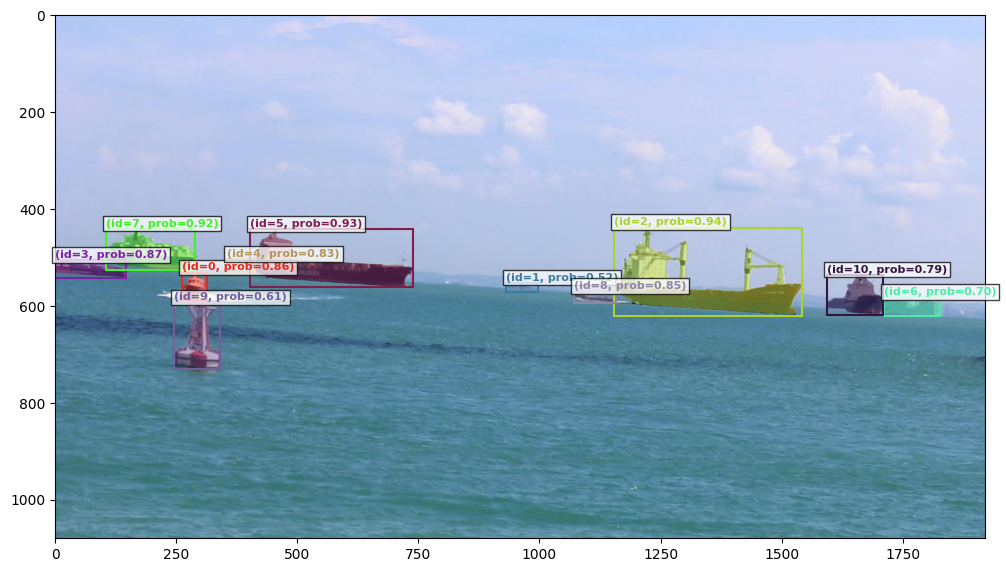

In [ ]:
prompt="boat"
output = processor.set_text_prompt(state=inference_state, prompt=prompt)

img0 = Image.open(image_path)
plot_results(img0, output)

In [ ]:
# box_input_xywh = torch.tensor([400.0, 0.0, 110.0, 110.0]).view(-1, 4)
# box_input_cxcywh = box_xywh_to_cxcywh(box_input_xywh)

# norm_box_cxcywh = normalize_bbox(box_input_cxcywh, width, height).flatten().tolist()
# print("Normalized box input:", norm_box_cxcywh)

# processor.reset_all_prompts(inference_state)
# inference_state = processor.add_geometric_prompt(
#     state=inference_state, box=norm_box_cxcywh, label=True
# )

# img0 = Image.open(image_path)
# image_with_box = draw_box_on_image(img0, box_input_xywh.flatten().tolist())
# plt.imshow(image_with_box)
# plt.axis("off")  # Hide the axis
# plt.show()

In [ ]:
# plot_results(img0, inference_state)

### Video Inference


In [ ]:
import cv2

from sam3.model_builder import build_sam3_video_predictor

from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12


def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
            propagation_direction="forward"
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")

In [ ]:
video_predictor = build_sam3_video_predictor()
video_path = "./assets/videos/S1_ch1234_20251029_1413_1min.mp4" # a JPEG folder or an MP4 video file


INFO 2026-02-10 09:43:42,337 1221 sam3_video_predictor.py: 300: using the following GPU IDs: [0]
INFO 2026-02-10 09:43:42,338 1221 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-02-10 09:43:42,339 1221 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2026-02-10 09:43:45,415 1221 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-10 09:43:47,680 1221 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2026-02-10 09:43:47,681 1221 sam3_video_predictor.py: 331: 


	*** DONE loading model on all ranks ***




In [ ]:
# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.jpg"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.jpg" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

In [ ]:
# Start a session
response = video_predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

frame loading (OpenCV) [rank=0]: 100% 1500/1500 [00:06<00:00, 247.78it/s]


In [ ]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = video_predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

In [ ]:

prompt_text_str = "boat"
frame_idx = 0 

response = video_predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=response["session_id"],
        frame_index=frame_idx, # Arbitrary frame index
        text=prompt_text_str,
    )
)
output = response["outputs"]

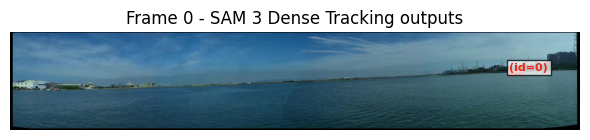

In [ ]:
plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: output})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

In [ ]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(video_predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, 360, vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

propagate_in_video:   0%|          | 0/1500 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 82.00 MiB. GPU 0 has a total capacity of 31.33 GiB of which 54.94 MiB is free. Including non-PyTorch memory, this process has 30.94 GiB memory in use. Of the allocated memory 29.15 GiB is allocated by PyTorch, and 1.19 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)